In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# installing/upgrading fastai2 
!pip install --upgrade fastai

# installing/upgrading fastbook
!pip install --upgrade fastbook

#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 4.6 MB/s eta 0:00:0000:0100:01m


In [2]:
%matplotlib inline

#hide
from fastbook import *

In [3]:
path = untar_data(URLs.IMAGENETTE_160)


In [4]:
t = get_image_files(path)
t[0]

Path('/root/.fastai/data/imagenette2-160/train/n03417042/n03417042_27613.JPEG')

https://docs.python.org/3/library/glob.html

In [5]:
from glob import glob
files = L(glob(f'{path}/**/*.JPEG', recursive=True)).map(Path)
files[0]

Path('/root/.fastai/data/imagenette2-160/train/n03417042/n03417042_27613.JPEG')

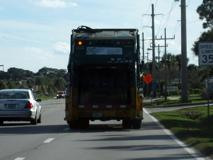

In [7]:
im = Image.open(files[4])
im

In [8]:
lbls = files.map(Self.parent.name()).unique(); lbls

(#10) ['n03417042','n03425413','n01440764','n02102040','n03888257','n03000684','n03445777','n03394916','n03028079','n02979186']

In [9]:
v2i = lbls.val2idx(); v2i

{'n03417042': 0,
 'n03425413': 1,
 'n01440764': 2,
 'n02102040': 3,
 'n03888257': 4,
 'n03000684': 5,
 'n03445777': 6,
 'n03394916': 7,
 'n03028079': 8,
 'n02979186': 9}

In [1]:
??lbls

Object `lbls` not found.


In [10]:
class Dataset:
    def __init__(self, fns): self.fns=fns
    def __len__(self): return len(self.fns)
    def __getitem__(self, i):
        im = Image.open(self.fns[i]).resize((64,64)).convert('RGB')
        y = v2i[self.fns[i].parent.name]
        return tensor(im).float()/255, tensor(y)

In [11]:
train_filt = L(o.parent.parent.name=='train' for o in files)
train,valid = files[train_filt],files[~train_filt]
len(train),len(valid)

(9469, 3925)

In [12]:
train_ds,valid_ds = Dataset(train),Dataset(valid)
x,y = train_ds[0]
x.shape,y

(torch.Size([64, 64, 3]), tensor(0))

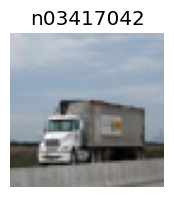

In [13]:
show_image(x, title=lbls[y]);

In [14]:
def collate(idxs, ds): 
    xb,yb = zip(*[ds[i] for i in idxs])
    return torch.stack(xb),torch.stack(yb)

In [15]:
x,y = collate([1,2], train_ds)
x.shape,y

(torch.Size([2, 64, 64, 3]), tensor([0, 0]))

In [16]:
class DataLoader:
    def __init__(self, ds, bs=128, shuffle=False, n_workers=1):
        self.ds,self.bs,self.shuffle,self.n_workers = ds,bs,shuffle,n_workers

    def __len__(self): return (len(self.ds)-1)//self.bs+1

    def __iter__(self):
        idxs = L.range(self.ds)
        if self.shuffle: idxs = idxs.shuffle()
        chunks = [idxs[n:n+self.bs] for n in range(0, len(self.ds), self.bs)]
        with ProcessPoolExecutor(self.n_workers) as ex:
            yield from ex.map(collate, chunks, ds=self.ds)